In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(800, 1000)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   2%|▎         | 5/200 [08:36<5:36:21, 103.50s/it]

Converged after 440 iterations



Processing Samples:   4%|▍         | 9/200 [15:33<5:30:48, 103.92s/it]

Converged after 420 iterations



Processing Samples:   6%|▌         | 12/200 [20:49<5:28:17, 104.77s/it]

Converged after 472 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.59s/it]

Converged after 451 iterations



Processing Samples:   8%|▊         | 15/200 [26:02<5:20:51, 104.06s/it]

Converged after 441 iterations



Processing Samples:   8%|▊         | 17/200 [29:32<5:18:34, 104.45s/it]

Converged after 414 iterations



Processing Samples:   9%|▉         | 18/200 [31:23<5:22:14, 106.24s/it]

Converged after 469 iterations



Processing Samples:  11%|█         | 22/200 [38:31<5:15:41, 106.41s/it]

Converged after 437 iterations



Processing Samples:  12%|█▏        | 23/200 [40:14<5:10:27, 105.24s/it]

Converged after 379 iterations



Processing Samples:  14%|█▎        | 27/200 [47:21<5:05:33, 105.98s/it]

Converged after 427 iterations



Processing Samples:  14%|█▍        | 29/200 [50:49<4:58:24, 104.71s/it]

Converged after 402 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.84s/it]

Converged after 491 iterations



Processing Samples:  21%|██        | 42/200 [1:13:38<4:36:13, 104.89s/it]

Converged after 402 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.32s/it]

Converged after 487 iterations



Processing Samples:  23%|██▎       | 46/200 [1:20:40<4:29:56, 105.17s/it]

Converged after 466 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.76s/it]

Converged after 466 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.71s/it]

Converged after 456 iterations



Processing Samples:  28%|██▊       | 56/200 [1:38:01<4:09:45, 104.07s/it]

Converged after 474 iterations



Processing Samples:  31%|███       | 62/200 [1:48:30<4:01:10, 104.86s/it]

Converged after 476 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.74s/it]

Converged after 496 iterations



Processing Samples:  32%|███▎      | 65/200 [1:53:41<3:54:17, 104.13s/it]

Converged after 466 iterations



Processing Samples:  34%|███▍      | 69/200 [2:00:38<3:47:20, 104.13s/it]

Converged after 472 iterations



Processing Samples:  36%|███▌      | 72/200 [2:05:51<3:41:59, 104.06s/it]

Converged after 487 iterations



Processing Samples:  38%|███▊      | 77/200 [2:14:32<3:33:26, 104.11s/it]

Converged after 471 iterations



Processing Samples:  39%|███▉      | 78/200 [2:16:15<3:31:18, 103.92s/it]

Converged after 462 iterations



Processing Samples:  43%|████▎     | 86/200 [2:30:10<3:17:22, 103.88s/it]

Converged after 372 iterations



Processing Samples:  44%|████▎     | 87/200 [2:31:50<3:13:36, 102.80s/it]

Converged after 414 iterations



Processing Samples:  44%|████▍     | 89/200 [2:35:19<3:11:53, 103.73s/it]

Converged after 482 iterations



Processing Samples:  45%|████▌     | 90/200 [2:37:04<3:10:36, 103.97s/it]

Converged after 462 iterations



Processing Samples:  46%|████▌     | 92/200 [2:40:32<3:06:55, 103.84s/it]

Converged after 422 iterations



Processing Samples:  48%|████▊     | 96/200 [2:47:28<2:59:57, 103.82s/it]

Converged after 422 iterations



Processing Samples:  48%|████▊     | 97/200 [2:49:13<2:58:33, 104.02s/it]

Converged after 490 iterations



Processing Samples:  50%|█████     | 100/200 [2:54:27<2:54:20, 104.61s/it]

Converged after 496 iterations



Processing Samples:  51%|█████     | 102/200 [2:57:56<2:50:26, 104.35s/it]

Converged after 480 iterations



Processing Samples:  52%|█████▎    | 105/200 [3:03:10<2:45:37, 104.61s/it]

Converged after 491 iterations



Processing Samples:  53%|█████▎    | 106/200 [3:04:52<2:42:49, 103.93s/it]

Converged after 410 iterations



Processing Samples:  54%|█████▎    | 107/200 [3:06:36<2:41:05, 103.92s/it]

Converged after 462 iterations



Processing Samples:  55%|█████▌    | 110/200 [3:11:50<2:36:24, 104.27s/it]

Converged after 474 iterations



Processing Samples:  56%|█████▌    | 111/200 [3:13:34<2:34:48, 104.37s/it]

Converged after 482 iterations



Processing Samples:  56%|█████▌    | 112/200 [3:15:17<2:32:19, 103.86s/it]

Converged after 431 iterations



Processing Samples:  56%|█████▋    | 113/200 [3:17:00<2:30:06, 103.52s/it]

Converged after 423 iterations



Processing Samples:  59%|█████▉    | 118/200 [3:25:42<2:22:19, 104.15s/it]

Converged after 475 iterations



Processing Samples:  63%|██████▎   | 126/200 [3:39:39<2:08:53, 104.51s/it]

Converged after 485 iterations



Processing Samples:  64%|██████▍   | 128/200 [3:43:06<2:04:47, 104.00s/it]

Converged after 427 iterations



Processing Samples:  66%|██████▌   | 131/200 [3:48:19<1:59:48, 104.18s/it]

Converged after 474 iterations



Processing Samples:  66%|██████▋   | 133/200 [3:51:46<1:55:59, 103.88s/it]

Converged after 442 iterations



Processing Samples:  68%|██████▊   | 135/200 [3:55:16<1:53:00, 104.32s/it]

Converged after 478 iterations



Processing Samples:  69%|██████▉   | 138/200 [4:00:29<1:47:50, 104.36s/it]

Converged after 491 iterations



Processing Samples:  72%|███████▏  | 143/200 [4:09:09<1:38:35, 103.77s/it]

Converged after 410 iterations



Processing Samples:  76%|███████▌  | 152/200 [4:24:47<1:23:15, 104.07s/it]

Converged after 474 iterations



Processing Samples:  76%|███████▋  | 153/200 [4:26:30<1:21:13, 103.70s/it]

Converged after 444 iterations



Processing Samples:  77%|███████▋  | 154/200 [4:28:09<1:18:19, 102.17s/it]

Converged after 414 iterations



Processing Samples:  78%|███████▊  | 156/200 [4:31:38<1:15:48, 103.37s/it]

Converged after 500 iterations



Processing Samples:  81%|████████  | 162/200 [4:42:11<1:06:24, 104.86s/it]

Converged after 434 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.48s/it]

Converged after 487 iterations



Processing Samples:  88%|████████▊ | 175/200 [5:04:59<43:31, 104.46s/it]

Converged after 435 iterations



Processing Samples:  88%|████████▊ | 176/200 [5:06:42<41:34, 103.95s/it]

Converged after 425 iterations



Processing Samples:  88%|████████▊ | 177/200 [5:08:24<39:40, 103.51s/it]

Converged after 429 iterations



Processing Samples:  96%|█████████▌| 191/200 [5:32:56<15:56, 106.27s/it]

Converged after 444 iterations



Processing Samples:  96%|█████████▌| 192/200 [5:34:41<14:07, 105.88s/it]

Converged after 436 iterations



Processing Samples:  98%|█████████▊| 196/200 [5:41:37<06:56, 104.04s/it]

Converged after 417 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.75s/it]

Converged after 390 iterations



Processing Samples:  98%|█████████▊| 197/200 [5:43:16<05:07, 102.62s/it]

Converged after 479 iterations



Processing Samples: 100%|██████████| 200/200 [5:48:31<00:00, 104.56s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [11.3   14.99  18.085 19.75  19.99  20.   ]
Avg SRR : [0.04669132 0.0783344  0.1242635  0.18076148 0.19924459 0.2       ]
Avg FR  : [1.09921053 0.77552632 0.43526316 0.095      0.00315789 0.        ]
Avg PR  : [0.07068162 0.10183427 0.13902152 0.18409229 0.19942619 0.2       ]
Avg RE  : [0.113   0.1499  0.18085 0.1975  0.1999  0.2    ]
Avg F1  : [0.08677307 0.12104764 0.15683    0.19036196 0.19965607 0.2       ]
Avg NMSE: [0.12703457 0.08590636 0.04432961 0.01443675 0.00486854 0.00175316]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-all-pilot-length-30-set-5.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


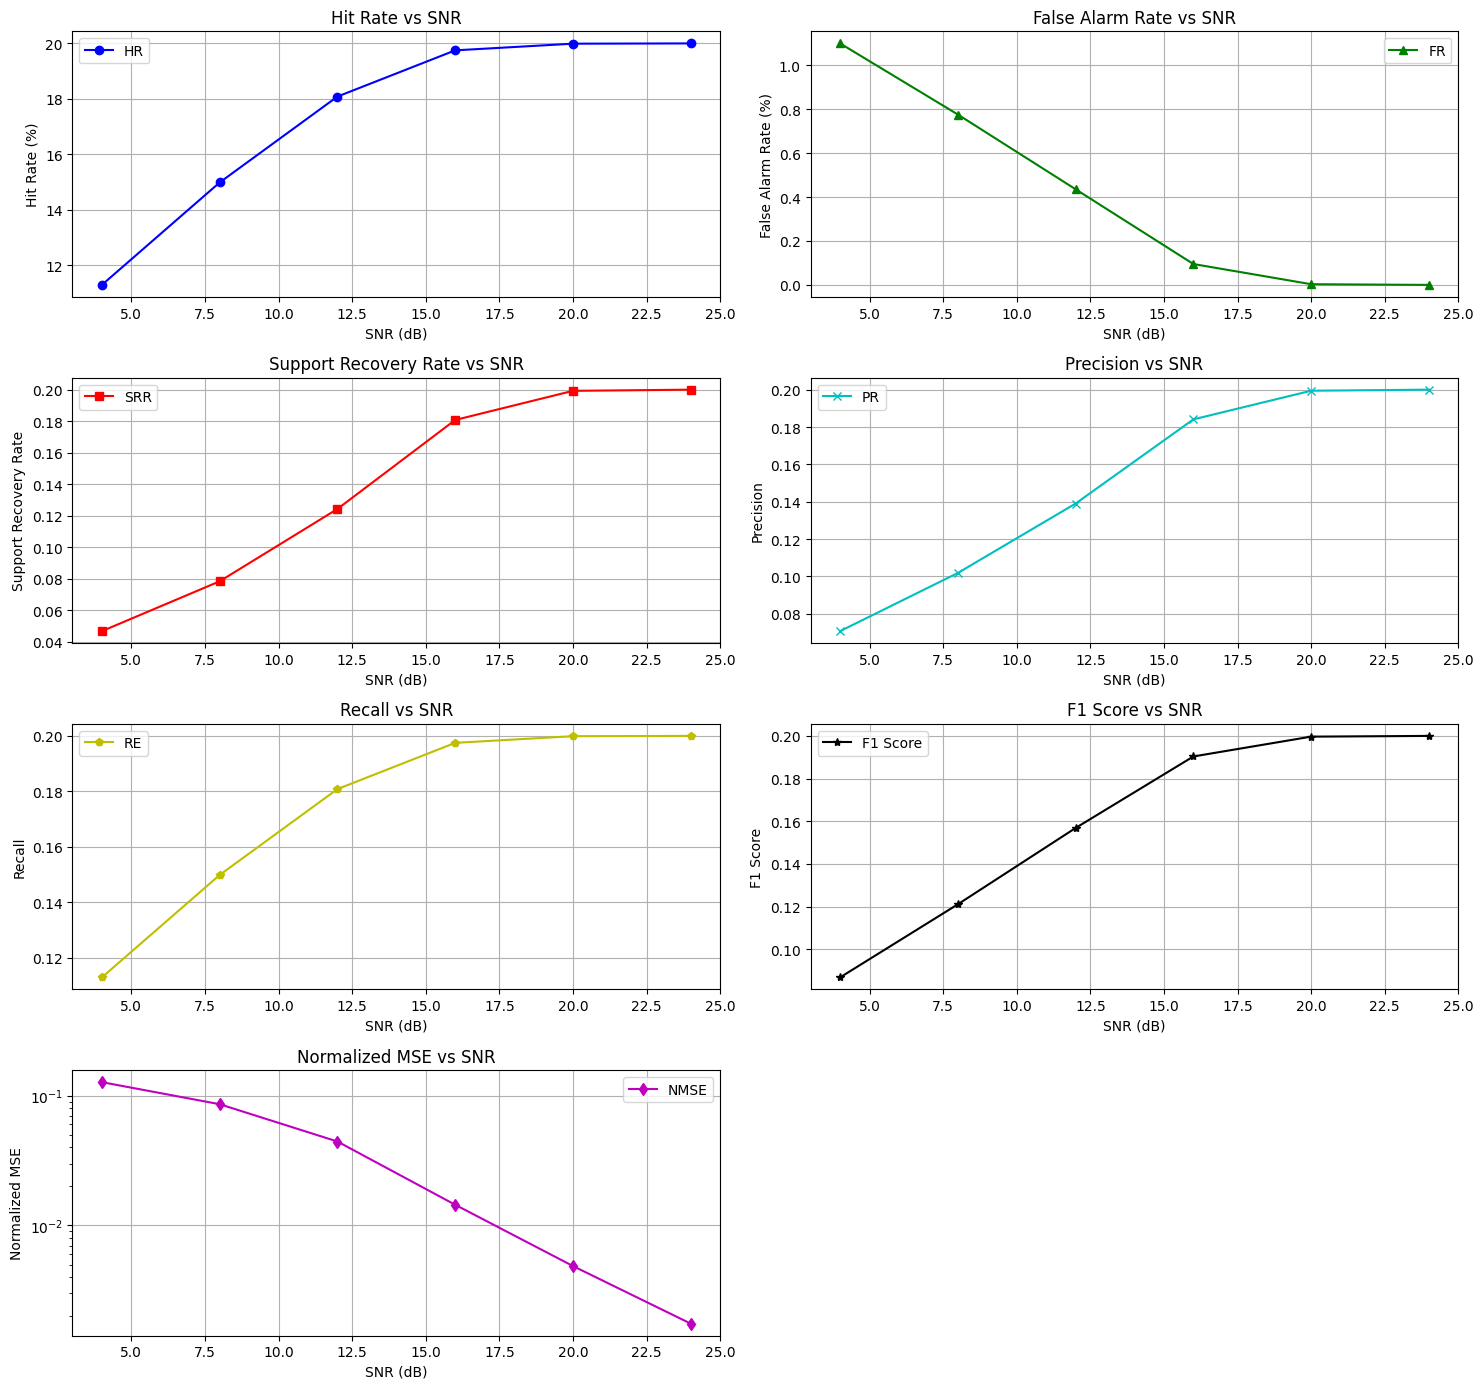

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

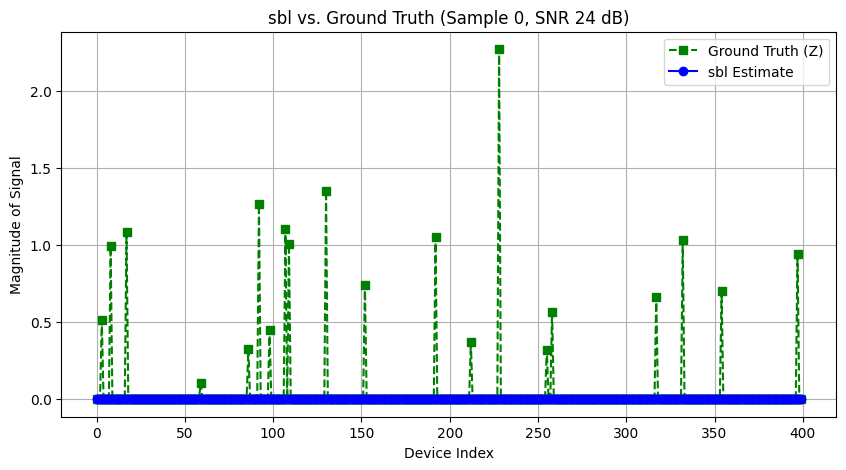

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


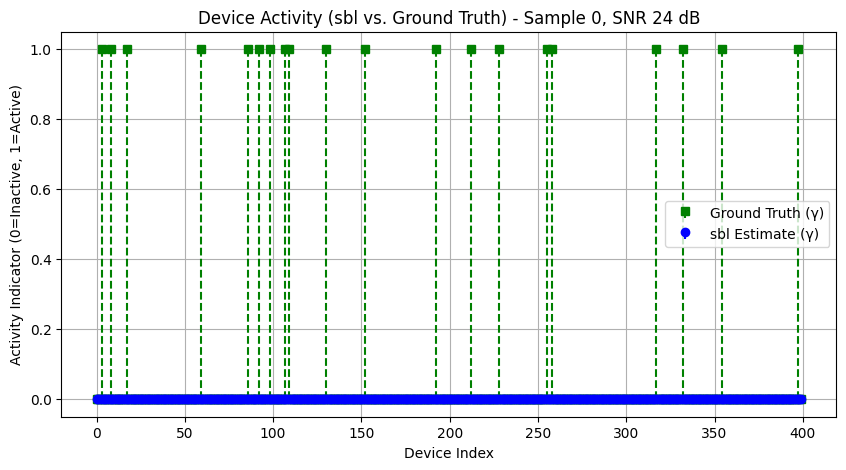

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)